In [1]:
# imports
import os
import imp
import numpy as np
import pandas as pd
import theano
import lasagne
import loading
from training import *
from network import *
from architectures import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bayes_mvs as bmvs

%matplotlib inline

# aliases
L = lasagne.layers
nl = lasagne.nonlinearities
T = theano.tensor

In [9]:
# data loading
headdir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
paramsdir = os.path.join(headdir, 'Analysis/0_hvh/Params/nnets/temp')
datadir = os.path.join(headdir, 'Data/model input')
# datafile = os.path.join(headdir, 'Data/0_hvh/Clean/_summaries/model_input_with_groups.csv')
resultsdir = os.path.join(headdir, 'Analysis/0_hvh/Loglik/nnets')
# data = loading.default_loader(datafile)

datafilenames = ['0 (with groups)', '1 (with computer)', '2 (with computer)', '3 (with computer)', '4']
datafilenames = [os.path.join(datadir, fname + '.csv') for fname in datafilenames]
colnames = ['subject', 'color', 'bp', 'wp', 'zet', 'rt']

e0 = pd.read_csv(datafilenames[0], names=colnames+['splitno'])
e1 = pd.read_csv(datafilenames[1], names=colnames)
e2 = pd.read_csv(datafilenames[2], names=colnames)
e3 = pd.read_csv(datafilenames[3], names=colnames+['task', 'taskorder', 'session'])
e4 = pd.read_csv(datafilenames[4], names=colnames+['timecondition'])

Es = [e1, e2, e3, e4]
for i, e in enumerate(Es[1:]):
    e['subject'] = e['subject'] + Es[i-1].loc[Es[i-1]['subject']<1000, 'subject'].max()

A = pd.concat([e[colnames] for e in [e1, e2, e3, e4]])

groups = np.arange(len(A))%5 + 1
np.random.seed(100001)
np.random.shuffle(groups)
A['group'] = groups

A.to_csv(os.path.join(datadir, '1-4.csv'), encoding='ASCII', header=False, index=False)
A.loc[A['subject']<1000, :].to_csv(
    os.path.join(datadir, '1-4 (no computer).csv'), 
    encoding='ASCII', header=False, index=False
)

In [10]:
data = loading.default_loader(os.path.join(datadir, '1-4 (no computer).csv'))

# Prototyping

### Baseline CNN performance on Experiments 1-4

In [12]:
def prototype(input_var=None):
    input_shape = (None, 2, 4, 9)
    FixLayer = make_FixLayer(input_var)

    input_layer = L.InputLayer(shape=input_shape, input_var=input_var)
    network = L.Conv2DLayer(
        input_layer, num_filters=32, filter_size=(4,4), pad='full',
        nonlinearity=nl.identity
    )

    network = L.ParametricRectifierLayer(network, shared_axes='auto') # default: auto
    network = L.FeaturePoolLayer(network, pool_function=T.sum, pool_size=2) # default: T.sum, 2
    network = L.DropoutLayer(network, p=.75) # default: .75
    network = L.DenseLayer(
        network, num_units=36,
        nonlinearity=nl.very_leaky_rectify, W=lasagne.init.HeUniform(gain='relu')
    )
    network = FixLayer(network)
    network = L.NonlinearityLayer(network, nonlinearity=nl.softmax)
    network = FixLayer(network)
    network = ReNormLayer(network)

    return network

trainer = DefaultTrainer(stopthresh=100) # default: 125
net_list = trainer.train_all(architecture=prototype, data=data, seed=985227)

for i, n in enumerate(net_list):
    n.save_params(os.path.join(paramsdir, '{} split agg fit exp 1-4'.format(i)))

(12362, 2, 4, 9)
Epoch 0 took 16.673s
	training loss:			2.6981
	validation loss:		2.5322
	validation accuracy:		22.75%
	total time elapsed:		16.945s
Epoch 50 took 15.195s
	training loss:			2.1220
	validation loss:		1.9659
	validation accuracy:		40.54%
	total time elapsed:		795.825s
Epoch 100 took 15.196s
	training loss:			2.1086
	validation loss:		1.9451
	validation accuracy:		41.02%
	total time elapsed:		1570.664s
Epoch 150 took 15.346s
	training loss:			2.0972
	validation loss:		1.9463
	validation accuracy:		41.43%
	total time elapsed:		2364.337s
Epoch 200 took 15.640s
	training loss:			2.0945
	validation loss:		1.9386
	validation accuracy:		41.49%
	total time elapsed:		3147.492s
Abandon ship!
TEST PERFORMANCE
	Stopped in epoch:		231
	Test loss:			1.9396
	Test accuracy:			41.59%
(12396, 2, 4, 9)
Epoch 0 took 16.167s
	training loss:			2.6881
	validation loss:		2.5109
	validation accuracy:		24.21%
	total time elapsed:		16.419s
Epoch 50 took 15.445s
	training loss:			2.1298
	validation 

In [33]:
hvhdata = loading.default_loader(os.path.join(datadir, '0 (with groups).csv'))
Xs = hvhdata[2]
ys = hvhdata[3]
Ss = np.concatenate(hvhdata[4])
Xs = np.concatenate(Xs)
ys = np.concatenate(ys)
Xs.shape

(5482, 2, 4, 9)

In [25]:
nlls = []
results = []
for net in net_list:
    nll = net.test_fn(Xs, ys)
    nlls.append(nll[0])
    res = net.itemized_test_fn(Xs, ys)
    results.append(res)

In [44]:
nlls_array = np.array(nlls)
results_array = np.array(results)
bmvs(nlls_array)

(Mean(statistic=2.0640209870003878, minmax=(2.0565099414769299, 2.0715320325238458)),
 Variance(statistic=0.0001241334460871802, minmax=(2.6167156672782504e-05, 0.00034931595670877909)),
 Std_dev(statistic=0.0098739141465311268, minmax=(0.0051153843133026188, 0.018689996166633614)))

In [43]:
subresults = []
for s in np.unique(Ss):
    idx = np.where(Ss==s)[0]
    res = results_array[:, idx].mean()
    subresults.append(res)
bmvs(np.array(subresults), alpha=.95)

(Mean(statistic=2.0529852212908963, minmax=(1.9476852219908463, 2.1582852205909466)),
 Variance(statistic=0.11426693138680367, minmax=(0.072743842325896993, 0.17873587770463698)),
 Std_dev(statistic=0.33575788235153775, minmax=(0.26971066409375988, 0.42277166142568845)))

# Prototyping Tuning

In [53]:
class FineTuner(DefaultTrainer):
    """
    Trainer to fine tune networks to individual subjects

    Consider moving freeze, param set functions properly into Network object
    Abstracting split functions and augment in DefaultTrainer would be good too
    """

    def train_all(self, architecture, data, split, seed=None, startparams=None, freeze=True, save_params=False):
        if seed:
            np.random.seed(seed)

        D, groups, Xs, ys, Ss = data
        num_splits = len(Xs)
        r = np.tile(np.arange(num_splits), [num_splits, 1])
        r = (r + r.T) % num_splits

        starttime = time.time()
        net = Network(architecture)
        if startparams:
            _layers = L.get_all_layers(net.net)
            L.set_all_param_values(_layers, startparams)
            convlayer, prelulayer = _layers[1:3]
            if freeze:
                convlayer.params[convlayer.W].remove('trainable')
                convlayer.params[convlayer.b].remove('trainable')
                prelulayer.params[prelulayer.alpha].remove('trainable')

        train_idxs = r[split, :3]
        val_idxs = r[split, 3:4]
        test_idxs = r[split, 4:]

        X, y, S = [np.concatenate(np.array(Z)[train_idxs]) for Z in [Xs, ys, Ss]]
        Xv, yv, Sv = [np.concatenate(np.array(Z)[val_idxs]) for Z in [Xs, ys, Ss]]
        Xt, yt, St = [np.concatenate(np.array(Z)[test_idxs]) for Z in [Xs, ys, Ss]]
        X, y = augment((X, y))
        S = np.concatenate([S, S, S, S])
        self.train(net, training_data=(X, y), validation_data=(Xv, yv))
        self.test(net, testing_data=(Xt, yt))
        time_elapsed = time.time() - starttime

        return net

In [54]:
tune_results = np.zeros([40, 5, 5])
tuner = FineTuner(stopthresh=25)

for i, n in enumerate(net_list):
    for j in range(5):
        params = L.get_all_param_values(n.net)
        subnet = tuner.train_all(architecture=prototype, data=hvhdata, split=j, startparams=params, freeze=True)
        subnet.save_params(os.path.join(paramsdir, '{} agg fit exp 1-4 {} tune fit exp 0'.format(i, j)))
        
        res = subnet.itemized_test_fn(Xs, ys)
        for s in np.unique(Ss):
            idx = np.where(Ss==s)[0]
            tune_results[s, j, i] = res[idx].mean()

Epoch 0 took 1.545s
	training loss:			2.2400
	validation loss:		1.9872
	validation accuracy:		41.60%
	total time elapsed:		1.571s
Abandon ship!
TEST PERFORMANCE
	Stopped in epoch:		45
	Test loss:			2.0473
	Test accuracy:			38.18%
Epoch 0 took 1.356s
	training loss:			2.2406
	validation loss:		2.0766
	validation accuracy:		39.45%
	total time elapsed:		1.377s
Abandon ship!
TEST PERFORMANCE
	Stopped in epoch:		32
	Test loss:			1.9593
	Test accuracy:			40.72%
Epoch 0 took 1.289s
	training loss:			2.2414
	validation loss:		1.9977
	validation accuracy:		42.77%
	total time elapsed:		1.311s
Abandon ship!
TEST PERFORMANCE
	Stopped in epoch:		34
	Test loss:			2.0117
	Test accuracy:			38.48%
Epoch 0 took 1.592s
	training loss:			2.2406
	validation loss:		2.0620
	validation accuracy:		38.48%
	total time elapsed:		1.625s
Abandon ship!
TEST PERFORMANCE
	Stopped in epoch:		40
	Test loss:			1.9980
	Test accuracy:			39.75%
Epoch 0 took 1.571s
	training loss:			2.2441
	validation loss:		2.0192
	validati

In [62]:
def load_params(net, paramsfile):
    with np.load(paramsfile) as loaded:
        params_list = [(i[0], i[1]) for i in loaded.items()]
        params_list.sort()
        L.set_all_param_values(net.net, [i[1] for i in params_list])

    return None

In [63]:
tune_results = np.zeros([40, 5, 5])
tuner = FineTuner(stopthresh=25)

for i, n in enumerate(net_list):
    for j in range(5):
        params = L.get_all_param_values(n.net)
#         subnet = tuner.train_all(architecture=prototype, data=hvhdata, split=j, startparams=params, freeze=True)
#         subnet.save_params(os.path.join(paramsdir, '{} agg fit exp 1-4 {} tune fit exp 0'.format(i, j)))
        
        subnet = Network(prototype)
        load_params(subnet, os.path.join(paramsdir, '{} agg fit exp 1-4 {} tune fit exp 0.npz'.format(i, j)))
        res = subnet.itemized_test_fn(Xs, ys)
        for s in np.unique(Ss):
            idx = np.where(Ss==s)[0]
            tune_results[s, j, i] = res[idx].mean()

In [67]:
bmvs(tune_results.mean(axis=(1,2)))

(Mean(statistic=1.8895031381739038, minmax=(1.8097881110292786, 1.969218165318529)),
 Variance(statistic=0.094377362595261444, minmax=(0.063987902994348825, 0.1358983989627362)),
 Std_dev(statistic=0.30514049970042506, minmax=(0.25295830287687499, 0.36864400030752731)))

In [90]:
trout = tune_results.reshape([40, 25])
np.savetxt(os.path.join(resultsdir, 'arch32 agg fit exp 1-4 agg tune fit exp 0.csv'), trout, fmt='%.18f', delimiter=',')

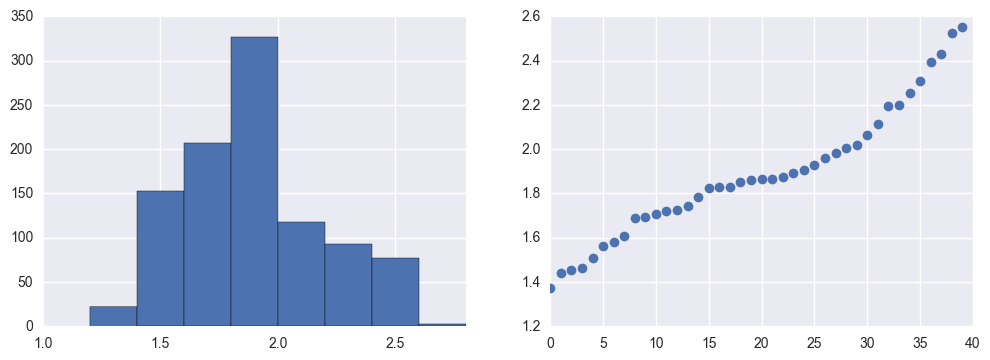

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)

ax = axes[0, 0]
ax.hist(trout.flatten(), bins=np.arange(1.2, 3.0, .15))

ax = axes[0, 1]

mos = [bmv(trout[i, :], alpha=.95) for i in np.arange(40)]
means = np.array([mo[0][0] for mo in mos])
lbs = [mo[]]
orderidx = trout.mean(axis=1).argsort()
ax.plot(np.arange(40), trout[orderidx, :].mean(axis=1), marker='o', linestyle='None')

sns.despine();

In [85]:
orderidx

array([18, 27, 20, 31, 30, 35, 33,  5, 19, 15, 21, 26,  2, 10, 34,  1, 13,
       25,  7,  4, 12, 38, 14, 32,  3, 22,  6, 24,  0, 39, 11, 29,  9, 36,
       16, 23, 28,  8, 37, 17])